# Visualizing the saliency maps

Once your classifier is trained you can visualize which pixels where the most relevant to estimate the volume of wine (or any other liquid) in an image. This is what we call the *saliency maps*.

We will use the implementations of different saliency functions from the [deep-viz repository](https://github.com/experiencor/deep-viz-keras) by [experiencor](https://github.com/experiencor) which allows the visualization of saliency maps for keras models.

In [1]:
import os
import json

import numpy as np
import matplotlib.pylab as plt
from tensorflow.keras.models import load_model

from imgclas import paths, utils, data_utils
from imgclas.data_utils import load_data_splits, k_crop_data_sequence
from imgclas.test_utils import predict
from imgclas.visualization.saliency import GradientSaliency
from imgclas.visualization.guided_backprop import GuidedBackprop
from imgclas.visualization.integrated_gradients import IntegratedGradients
from imgclas.visualization.visual_backprop import VisualBackprop

# User parameters to set
TIMESTAMP = '2021-11-03_Lab_All_CopasVasos_All_reg'                       # timestamp of the model
MODEL_NAME = 'final_model.h5'                           # model to use to make the prediction
TOP_K = 2                                               # number of top classes predictions to save

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load training configuration
conf_path = os.path.join(paths.get_conf_dir(), 'conf.json')
with open(conf_path) as f:
    conf = json.load(f)
    
# Load the model
model = load_model(os.path.join(paths.get_checkpoints_dir(), MODEL_NAME), custom_objects=utils.get_custom_objects(), compile=True)

W1124 12:51:47.770589 140616941311808 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1124 12:51:47.773281 140616941311808 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1124 12:51:47.775028 140616941311808 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

Now you can select a file in your computer in which to visualize the saliency maps. 
Possible visualizations include:
* [Vanila gradient](https://arxiv.org/abs/1312.6034)
* [Guided backprop](https://arxiv.org/abs/1412.6806)
* [Integrated gradients](https://arxiv.org/abs/1703.01365)
* [Visual backprop](https://arxiv.org/abs/1611.05418)

Each of them is accompanied with the corresponding [smoothgrad](https://arxiv.org/abs/1706.03825) version, which improves on any baseline method by adding random noise.

[1/2] GradientSaliency
[2/2] IntegratedGradients
1/1 [==============================] - 3s 3s/step
Predicted value:
259.6368408203125


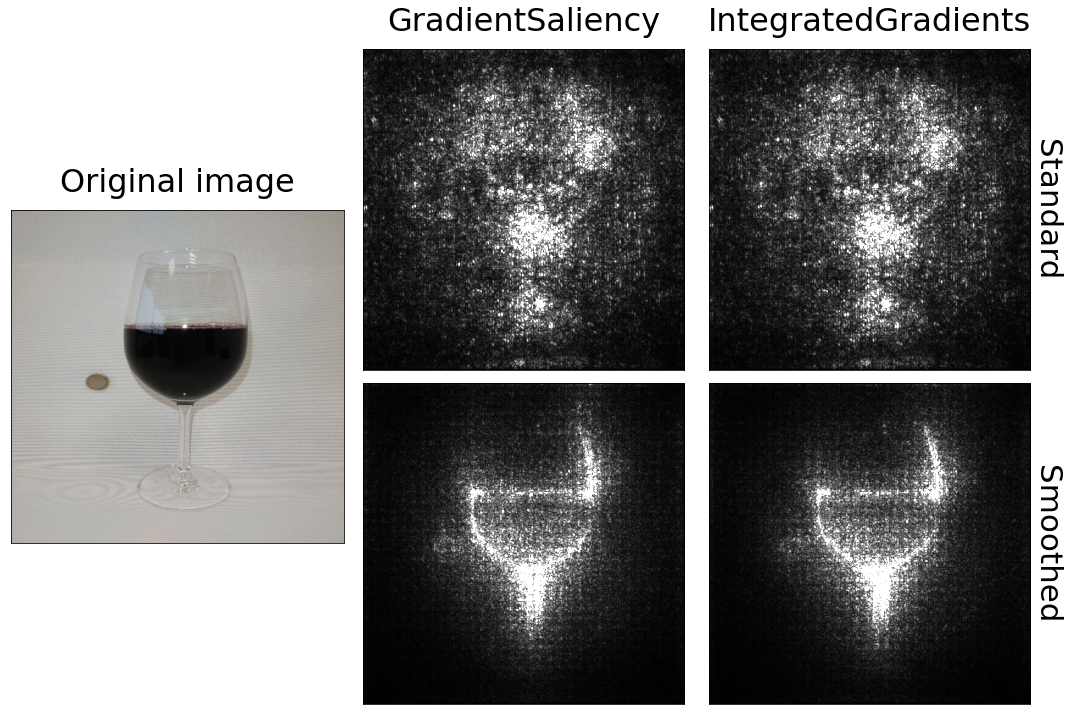

In [2]:
FILEPATH = '/srv/datos/Laboratorio/La Rioja/CIBIR/copa Burdeos/Est_Rio_C_Bur_275_nd_f_bl_con_me_cen.jpg'
saliency_types = [GradientSaliency, IntegratedGradients] # --> VisualBackprop seems to give errors
# https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error

figsize = 5
fig, axs = plt.subplots(2, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)+1), figsize*2))
# axs = axs.T.flatten() # lo hacemos despues

gs = axs[0, 0].get_gridspec()
# remove the underlying axes
for ax in axs[0:, 0]:
    ax.remove()
axbig = fig.add_subplot(gs[0:, 0])

# Load the image and preprocess it for the saliency maps computation
data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

img_arr = data_gen.__getitem__(0)
img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#, filemode='local')
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])

axbig.imshow(image)
axbig.set_title('Original image', fontsize=32, pad=18)
axbig.set_xticks([])
axbig.set_yticks([])
axbig.xaxis.set_visible(False)
axbig.yaxis.set_visible(False)
axs = axs.T.flatten()
# fig.delaxes(axs[1])
axs = axs[2:]

# Saliency maps
# si queremos poner las ylabel a la dcha de los ejes
axs[2].set_ylabel('Standard', fontsize=31,rotation=270, labelpad=31)
axs[3].set_ylabel('Smoothed', fontsize=31,rotation=270, labelpad=31)
# si queremos poner las ylabel a la izda de los ejes
# axs[0].set_ylabel('Standard', fontsize=12)
# axs[1].set_ylabel('Smoothed', fontsize=12)
for i, f in enumerate(saliency_types):
    print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
    saliency_func = f(model)
    
    # Normal map
    mask = saliency_func.get_mask(img_arr)
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    axs[i*2].set_title(saliency_func.__class__.__name__, fontsize=32, pad=18)
    
    # Smoothgrad map
    mask = saliency_func.get_smoothed_mask(img_arr) # el error esta en get_smoothed_mask de visual_backprop
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2+1].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.yaxis.set_label_position("right")

fig.tight_layout(pad=1.0)
plt.savefig('/srv/image-results/saliencyMaps/SM_Est_Rio_C_Bur_275_nd_f_bl_con_me_cen.png',bbox_inches='tight')
# Print predicted labels
pred_value = predict(model, FILEPATH, conf)#, filemode='local')
print('Predicted value:')
print('{}'.format(pred_value[0]))

[1/2] GradientSaliency
[2/2] IntegratedGradients
1/1 [==============================] - 2s 2s/step
Predicted value:
146.4781036376953


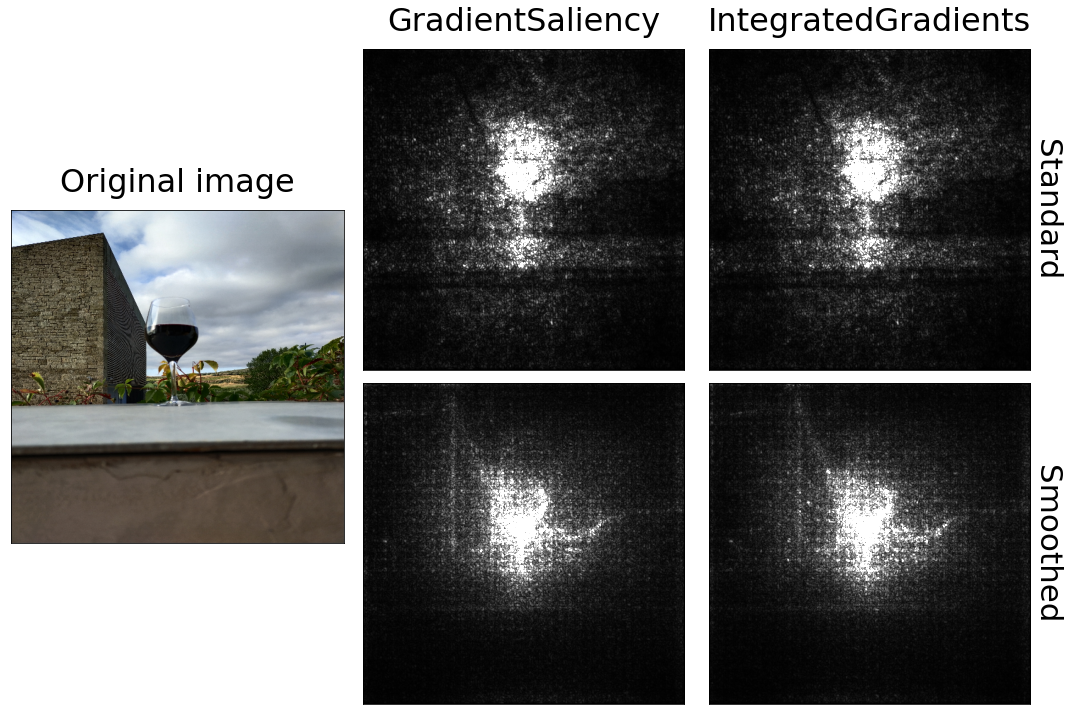

In [3]:
FILEPATH = '/srv/datos/Laboratorio/La Rioja/ICVV/Copa Chardonnay/Est_Rio_R_Char_150_nd_ext_nd_nd_al_inf.jpg'
saliency_types = [GradientSaliency, IntegratedGradients] # --> VisualBackprop seems to give errors
# https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error

figsize = 5
fig, axs = plt.subplots(2, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)+1), figsize*2))
# axs = axs.T.flatten() # lo hacemos despues

gs = axs[0, 0].get_gridspec()
# remove the underlying axes
for ax in axs[0:, 0]:
    ax.remove()
axbig = fig.add_subplot(gs[0:, 0])

# Load the image and preprocess it for the saliency maps computation
data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

img_arr = data_gen.__getitem__(0)
img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#, filemode='local')
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])

axbig.imshow(image)
axbig.set_title('Original image', fontsize=32, pad=18)
axbig.set_xticks([])
axbig.set_yticks([])
axbig.xaxis.set_visible(False)
axbig.yaxis.set_visible(False)
axs = axs.T.flatten()
# fig.delaxes(axs[1])
axs = axs[2:]

# Saliency maps
# si queremos poner las ylabel a la dcha de los ejes
axs[2].set_ylabel('Standard', fontsize=31, rotation=270, labelpad=31)
axs[3].set_ylabel('Smoothed', fontsize=31, rotation=270, labelpad=31)
# si queremos poner las ylabel a la izda de los ejes
# axs[0].set_ylabel('Standard', fontsize=12)
# axs[1].set_ylabel('Smoothed', fontsize=12)
for i, f in enumerate(saliency_types):
    print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
    saliency_func = f(model)
    
    # Normal map
    mask = saliency_func.get_mask(img_arr)
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    axs[i*2].set_title(saliency_func.__class__.__name__, fontsize=32, pad=18)
    
    # Smoothgrad map
    mask = saliency_func.get_smoothed_mask(img_arr) # el error esta en get_smoothed_mask de visual_backprop
    mask = np.sum(np.abs(mask), axis=2)
    axs[i*2+1].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.yaxis.set_label_position("right")

fig.tight_layout(pad=1.0)
plt.savefig('/srv/image-results/saliencyMaps/SM_Est_Rio_R_Char_150_nd_ext_nd_nd_al_inf.png',bbox_inches='tight')
# Print predicted labels
pred_value = predict(model, FILEPATH, conf)#, filemode='local')
print('Predicted value:')
print('{}'.format(pred_value[0]))